In [ ]:
import numpy as np
from copy import deepcopy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from skopt import gp_minimize
from skopt.space import Real

# -----------------------------
# 1. Fake 15D growth function
# -----------------------------
def true_growth_15D(x, noise=0.05):
    """Fake growth function depending on 15 chemical concentrations."""
    # Non-linear combination of some chemicals + noise
    val = (
        np.sin(3*np.pi*x[0]) * np.cos(2*np.pi*x[1])
        + 0.5*x[2]**2
        - 0.3*(x[3]-0.5)**2
        + np.sin(5*np.pi*x[4])
        + np.sum(np.sin(2*np.pi*x[5:10]))
        - np.sum((x[10:15]-0.5)**2)
    )
    return val + np.random.normal(0, noise)

# -----------------------------
# 2. Generate fake initial training data
# -----------------------------
np.random.seed(42)
n_samples = 50
n_dims = 15
X_train = np.random.rand(n_samples, n_dims)
y_train = np.array([true_growth_15D(x) for x in X_train])



/Users/antoinegueguen/Desktop/Hackathon_monomer/monomer_hackathon_2025/.venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/var/folders/9g/q_w246652jsfrgt3684zkxf40000gn/T/ipykernel_7201/4085889442.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return -float(pred)  # maximize growth
/var/folders/9g/q_w246652jsfrgt3684zkxf40000gn/T/ipykernel_7201/4085889442.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated 

Next 5 suggested reactions to test:
Reaction 1: ['0.5695', '1.0000', '1.0000', '1.0000', '0.3441', '1.0000', '0.1326', '0.0000', '0.0000', '0.0000', '0.0000', '1.0000', '0.0000', '0.0000', '0.0028']
Reaction 2: ['0.2252', '0.7753', '0.0000', '0.6476', '0.2102', '0.5108', '0.0000', '0.0618', '0.1633', '0.4672', '0.5436', '0.4699', '0.7648', '0.0303', '0.0228']
Reaction 3: ['0.9990', '0.6351', '0.6959', '0.1911', '0.1033', '0.3590', '0.0000', '0.0000', '0.0000', '0.0000', '0.4124', '0.3780', '0.1812', '0.0000', '0.2703']
Reaction 4: ['0.7434', '0.1397', '0.0898', '1.0000', '0.1245', '0.4518', '0.0000', '0.0541', '0.0000', '0.5848', '0.0274', '1.0000', '0.0000', '0.1933', '0.2795']
Reaction 5: ['0.4661', '0.0488', '0.0000', '0.8633', '0.2185', '0.2260', '0.1808', '0.0000', '0.0514', '1.0000', '0.2539', '1.0000', '0.1907', '0.2469', '0.0339']


/var/folders/9g/q_w246652jsfrgt3684zkxf40000gn/T/ipykernel_7201/4085889442.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_current = np.append(y_current, float(pred))


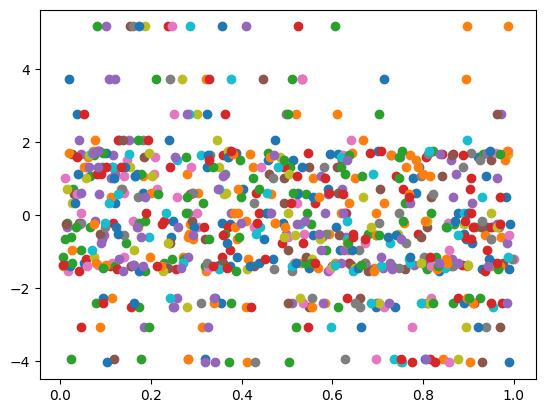

In [3]:
import matplotlib.pyplot as plt
plt.plot(X_train, y_train, 'o')
plt.show()

In [ ]:
# -----------------------------
# 3. Fit GP surrogate
# -----------------------------
kernel = ConstantKernel(1.0) * Matern(length_scale=0.2, nu=2.5) + WhiteKernel()
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=42)
gp.fit(X_train, y_train)

# -----------------------------
# 4. Define search space
# -----------------------------
space = [Real(0.0, 1.0, name=f"chem_{i+1}") for i in range(n_dims)]

# -----------------------------
# 5. Batch Bayesian Optimization (next 5 reactions)
# -----------------------------
n_suggestions = 5
X_current = X_train.copy()
y_current = y_train.copy()
gp_current = deepcopy(gp)
next_points = []

for _ in range(n_suggestions):
    # Objective for current GP
    def objective_single(x):
        x_arr = np.array(x).reshape(1,-1)
        pred, _ = gp_current.predict(x_arr, return_std=True)
        return -float(pred)  # maximize growth

    # Use gp_minimize to find next best point
    result = gp_minimize(
        func=objective_single,
        dimensions=space,
        n_calls=20,
        n_initial_points=5,
        acq_func="EI",
        random_state=42
    )
    
    next_point = result.x
    next_points.append(next_point)
    
    # Add predicted point to GP for next iteration
    pred, _ = gp_current.predict(np.array(next_point).reshape(1,-1), return_std=True)
    X_current = np.vstack([X_current, next_point])
    y_current = np.append(y_current, float(pred))
    gp_current.fit(X_current, y_current)

# -----------------------------
# 6. Print next 5 suggested reactions
# -----------------------------
print("Next 5 suggested reactions to test:")
for i, p in enumerate(next_points):
    print(f"Reaction {i+1}: {[f'{v:.4f}' for v in p]}")
